In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
import pandas as pd
import h5py
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
import re
from multiprocessing import cpu_count
from multiprocessing import Pool

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import sys
from functools import partial

from sklearn.metrics import confusion_matrix

In [10]:
# find GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (torch.cuda.device_count())

1


In [12]:
dataDir = 'dataFiles'
datasetSize = '100K'
earthquakeSampleFraction = 0.25
noiseSampleFraction = 0.25
csvFileName = f'{dataDir}/filtered_earthquakeSampleFraction_{earthquakeSampleFraction}_noiseSampleFraction_{noiseSampleFraction}.csv'
hdf5FileName = f'{dataDir}/filtered_earthquakeSampleFraction_{earthquakeSampleFraction}_noiseSampleFraction_{noiseSampleFraction}.hdf5'

trainSetFraction = 0.7
valSetFraction = 0.15
testSetFraction = 1 - (trainSetFraction + valSetFraction) 

# read the csv file
df_csv = pd.read_csv(csvFileName)

# set trace name as index
df_csv.set_index(['trace_name'], inplace=True)

# split the dataset into train, validation and test
df_train, df_val, df_test = np.split(df_csv.sample(frac = 1), [int(trainSetFraction*len(df_csv)), int((trainSetFraction + valSetFraction)*len(df_csv))])

# read the hdf5 file
hdf5Data = h5py.File(hdf5FileName, 'r')

In [13]:
# define other relevant dirNames

# dir to dump plots
plotImgDir = 'plotImages/cnn1d'
os.system(f'mkdir -p {plotImgDir}')

# directories to dump neuralNet params
netParamsDirName = 'netParams/cnn1d'
os.system(f'mkdir -p {netParamsDirName}')

0

In [14]:
# data loader

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, listIDs, labels):
        'Initialization'
        self.labels = labels
        self.listIDs = listIDs
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.listIDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.listIDs[index]

        # Load data and get label
        X = hdf5Data.get('data/' + ID)
        X = np.array(X)
        X = X.T
        y = self.labels[ID]

        return X, y

In [15]:
# define a 1D convolutional neural network

dropOutProb = 0.5

class Net(nn.Module):
    def __init__(self, dropOutProb = 0.5):
        
        # inherit base class
        super(Net, self).__init__()
        
        # layer 1
        self.conv1 = nn.Conv1d(in_channels = 3, out_channels = 12, kernel_size=5, stride = 1, padding = 2)
                
        # layer 2
        self.conv2 = nn.Conv1d(in_channels = 12, out_channels = 12, kernel_size=5, stride = 1, padding = 2)
                
        # layer 3
        self.conv3 = nn.Conv1d(in_channels = 12, out_channels = 8, kernel_size=5, stride = 1, padding = 2)
        
        # use downsampling by 2 for 1st 2 layers, and then downsample by 4 for the 3rd
        self.poolDiv2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.poolDiv4 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # dropout layer
        self.dropOut = nn.Dropout(p = dropOutProb)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features = 375 * 8, out_features = 16)
        self.fc2 = nn.Linear(in_features = 16, out_features = 16)
        self.fc3 = nn.Linear(in_features = 16, out_features = 1)

    def forward(self, x):
        x = self.poolDiv2(F.relu(self.conv1(x)))
        x = self.poolDiv2(F.relu(self.conv2(x)))
        x = self.poolDiv4(F.relu(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropOut(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):        
        size = x.size()[1:]
        num_features = 1        
        for s in size:
            num_features *= s            
        return num_features


net = Net(dropOutProb)
print(net.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv1d(3, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(12, 12, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(12, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (poolDiv2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (poolDiv4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (dropOut): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3000, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)>


In [16]:
# Loss criteria
criterion = nn.BCEWithLogitsLoss()

In [18]:
# convergence params
movingWindowSize = 20

# multiprocessing cpu params
numWorkers = 4

# define dataset variables to adapt to dataloader format

# training set. divide into batches inside the training loop
trainingListIDs = df_train.index.get_level_values('trace_name').tolist()
trainingLabels = (df_train['trace_category'] != 'noise').astype(float).to_dict()


# validation set
validationListIDs = df_val.index.get_level_values('trace_name').tolist()
validationLabels = (df_val['trace_category'] != 'noise').astype(float).to_dict()

validationSet = Dataset(validationListIDs, validationLabels)
validationGenerator = torch.utils.data.DataLoader(validationSet, batch_size = 256, num_workers = numWorkers)

# test set
testListIDs = df_test.index.get_level_values('trace_name').tolist()
testLabels = (df_test['trace_category'] != 'noise').astype(float).to_dict()

testSet = Dataset(testListIDs, testLabels)
testGenerator = torch.utils.data.DataLoader(testSet, batch_size = 256, num_workers = numWorkers)
    
# hyperParameters
numEpochs = 200
batchSize = 64
learningRateList = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
dropOutProbList = [0.3, 0.5, 0.7]


# training
lossProgression = np.zeros((len(dropOutProbList), len(learningRateList), numEpochs))
lossProgression[:] = np.nan

trainAccuracyProgression = np.zeros((len(dropOutProbList), len(learningRateList), numEpochs))
trainAccuracyProgression[:] = np.nan

valAccuracyProgression = np.zeros((len(dropOutProbList), len(learningRateList), numEpochs))
valAccuracyProgression[:] = np.nan

bestValAccuracy = np.zeros((len(dropOutProbList), len(learningRateList)))


for d,dropOutProb in enumerate (dropOutProbList):
    
    numBatches = int(len(df_train)/batchSize) + 1 if len(df_train) % batchSize != 0 else int(len(df_train)/batchSize)
    
    # invoke dataloader with appropriate batchSize
    trainingSet = Dataset(trainingListIDs, trainingLabels)
    trainingGenerator = torch.utils.data.DataLoader(trainingSet, batch_size = batchSize, shuffle=True, num_workers = numWorkers)        
    
    for l,learningRate in enumerate(learningRateList):
        
        # create a neuralNet object
        net = Net(dropOutProb)
        net.to(device)
        
        
        # optimizer type
        optimizer = optim.Adam(net.parameters(), lr=learningRate)
        
        # movingWindow of previous epochs to check for convergence
        deltaValAccuracyHistory = []
        prevValAccuracy = 0        
        
        fileTag = f'batchSize_{batchSize}_learningRate_{learningRate}_dropOutProb_{dropOutProb}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
        
        for epoch in range(numEpochs):                        
            
            # set network in training mode
            net.train()
            
            runningLoss = 0.0
            numErrors = 0.0
            for i, data in enumerate(trainingGenerator, 0):

                inputBatch, groundTruthBatch = data
                inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                outputPredBatch = net(inputBatch)        
                
                # compute loss
                loss = criterion(outputPredBatch,groundTruthBatch.unsqueeze(1))
                
                # backprop
                loss.backward()
                
                # gradient descent step
                optimizer.step()
                
                # output prediction label
                outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))

                # collect training loss, accuracy statistics
                if i == numBatches - 1:
                    runningLoss += loss.item() * (len(df_train) - i*batchSize)                    
                else:                        
                    runningLoss += loss.item() * batchSize
                
                numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()
            
            # track training loss/accuracy Progression
            avgLoss = runningLoss/len(df_train)
            lossProgression[d, l, epoch] = avgLoss
            trainAccuracy = 100 * (1 - numErrors/len(df_train))
            trainAccuracyProgression[d,l, epoch] = trainAccuracy
                        
            # evaluate validation set accuracy
            
            # set network in eval mode
            net.eval()
            
            numErrors = 0.0
            with torch.no_grad():
                
                for i, data in enumerate(validationGenerator, 0):

                    inputBatch, groundTruthBatch = data
                    inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)
                    outputPredBatch = net(inputBatch)
                    
                    # output prediction label
                    outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))
                    
                    numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()

            valAccuracy = 100 * (1 - numErrors/len(df_val))
            valAccuracyProgression[d,l,epoch] = valAccuracy
                        
            print('[batchSize = %d, dropOutProb = %.2g, learningRate = %.2g, epoch = %d] loss: %f, trainAccuracy: %f, valAccuracy: %f' %
                                                (batchSize, dropOutProb, learningRate, epoch + 1, avgLoss, trainAccuracy, valAccuracy))
            
            # update network parameters if validation accuracy in current epoch is better than the past            
            if valAccuracy > bestValAccuracy[d,l]:
                
                # store the neuralNet parameters in a file                
                path = f'{netParamsDirName}/cnn3Layer_12_12_8_fc2layer_16_16_{fileTag}.pth'
                torch.save(net.state_dict(), path)
                
                bestValAccuracy[d,l] = valAccuracy
            
            # check for convergence and exit early if valAccuracy is not improving
            deltaValAccuracy = valAccuracy - prevValAccuracy
            deltaValAccuracyHistory.insert(0, deltaValAccuracy)            
            
            if epoch >= movingWindowSize:
                deltaValAccuracyHistory.pop()
                
                if sum(deltaValAccuracyHistory) <= 0:
                    print ('Validation loss starting to decrease. Exiting...')
                    break
                
            prevValAccuracy = valAccuracy                        
        
        print ('Finished training...')
        print ('\n')

[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 1] loss: 0.704031, trainAccuracy: 54.190998, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 2] loss: 0.689921, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 3] loss: 0.690039, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 4] loss: 0.689968, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 5] loss: 0.689939, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 6] loss: 0.689945, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 7] loss: 0.689930, trainAccuracy: 54.103069, valAccuracy: 53.570557
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.01, epoch = 8] l

[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 18] loss: 0.170069, trainAccuracy: 98.208633, valAccuracy: 98.536263
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 19] loss: 0.054749, trainAccuracy: 98.543289, valAccuracy: 98.670998
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 20] loss: 0.046734, trainAccuracy: 98.730949, valAccuracy: 98.762863
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 21] loss: 0.052220, trainAccuracy: 98.765076, valAccuracy: 98.707741
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 22] loss: 0.071944, trainAccuracy: 98.825439, valAccuracy: 98.879227
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 23] loss: 0.052881, trainAccuracy: 98.826752, valAccuracy: 98.830231
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 24] loss: 0.036641, trainAccuracy: 98.902878, valAccuracy: 99.001717
[batchSize = 64, dropOutProb = 0.3, learningRate

[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 79] loss: 0.022067, trainAccuracy: 99.818893, valAccuracy: 99.577415
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 80] loss: 0.025746, trainAccuracy: 99.746719, valAccuracy: 99.565163
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 81] loss: 0.876634, trainAccuracy: 99.660095, valAccuracy: 99.522293
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 82] loss: 0.013757, trainAccuracy: 99.711281, valAccuracy: 99.491676
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 83] loss: 0.013494, trainAccuracy: 99.753281, valAccuracy: 99.565163
[batchSize = 64, dropOutProb = 0.3, learningRate = 0.0001, epoch = 84] loss: 0.270982, trainAccuracy: 99.744095, valAccuracy: 99.442673
Validation loss starting to decrease. Exiting...
Finished training...


[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-05, epoch = 1] loss: 3.992365, trainAccuracy: 62.575626, v

[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 3] loss: 2.246496, trainAccuracy: 56.196274, valAccuracy: 59.235668
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 4] loss: 1.261474, trainAccuracy: 56.008606, valAccuracy: 60.233955
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 5] loss: 1.753346, trainAccuracy: 56.255329, valAccuracy: 58.623226
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 6] loss: 3.739696, trainAccuracy: 56.145096, valAccuracy: 58.341503
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 7] loss: 1.192957, trainAccuracy: 56.030918, valAccuracy: 59.162174
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 8] loss: 1.419950, trainAccuracy: 56.685783, valAccuracy: 58.561981
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoch = 9] loss: 2.604004, trainAccuracy: 56.307827, valAccuracy: 58.286381
[batchSize = 64, dropOutProb = 0.3, learningRate = 1e-06, epoc

[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 21] loss: 0.071179, trainAccuracy: 97.569519, valAccuracy: 98.132042
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 22] loss: 0.060839, trainAccuracy: 97.829369, valAccuracy: 98.475014
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 23] loss: 0.061592, trainAccuracy: 97.909424, valAccuracy: 98.187164
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 24] loss: 0.062353, trainAccuracy: 97.825432, valAccuracy: 98.162666
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 25] loss: 0.054399, trainAccuracy: 98.062965, valAccuracy: 98.426018
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 26] loss: 0.057556, trainAccuracy: 98.129898, valAccuracy: 98.530128
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.001, epoch = 27] loss: 0.058659, trainAccuracy: 98.043282, valAccuracy: 98.695496
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.00

[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 27] loss: 0.036657, trainAccuracy: 99.019669, valAccuracy: 99.111954
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 28] loss: 0.036960, trainAccuracy: 99.043289, valAccuracy: 99.050713
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 29] loss: 0.033107, trainAccuracy: 99.148285, valAccuracy: 99.032333
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 30] loss: 0.210151, trainAccuracy: 99.068230, valAccuracy: 99.093582
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 31] loss: 0.038532, trainAccuracy: 99.094475, valAccuracy: 99.001717
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 32] loss: 3.037468, trainAccuracy: 98.922554, valAccuracy: 99.044586
[batchSize = 64, dropOutProb = 0.5, learningRate = 0.0001, epoch = 33] loss: 0.045782, trainAccuracy: 98.998672, valAccuracy: 99.081329
[batchSize = 64, dropOutProb = 0.5, learningRate

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 39] loss: 0.223073, trainAccuracy: 96.261108, valAccuracy: 96.919403
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 40] loss: 0.197468, trainAccuracy: 96.444832, valAccuracy: 96.943901
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 41] loss: 0.508910, trainAccuracy: 96.549820, valAccuracy: 96.980652
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 42] loss: 0.193940, trainAccuracy: 96.589195, valAccuracy: 97.090889
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 43] loss: 0.183297, trainAccuracy: 96.560326, valAccuracy: 97.066391
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 44] loss: 0.165081, trainAccuracy: 96.684998, valAccuracy: 97.146004
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 45] loss: 0.187016, trainAccuracy: 96.885788, valAccuracy: 97.446106
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-0

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 100] loss: 0.653176, trainAccuracy: 98.556412, valAccuracy: 98.750618
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 101] loss: 0.803877, trainAccuracy: 98.569534, valAccuracy: 98.701614
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 102] loss: 0.057042, trainAccuracy: 98.576096, valAccuracy: 98.707741
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 103] loss: 0.052219, trainAccuracy: 98.585281, valAccuracy: 98.738365
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 104] loss: 0.050624, trainAccuracy: 98.614159, valAccuracy: 98.787361
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 105] loss: 0.081906, trainAccuracy: 98.599716, valAccuracy: 98.744492
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 106] loss: 0.291583, trainAccuracy: 98.572159, valAccuracy: 98.719994
[batchSize = 64, dropOutProb = 0.5, learningRate

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 161] loss: 0.051719, trainAccuracy: 99.061668, valAccuracy: 99.191574
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 162] loss: 0.034207, trainAccuracy: 99.055107, valAccuracy: 99.148705
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 163] loss: 0.036098, trainAccuracy: 99.057732, valAccuracy: 99.167076
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 164] loss: 0.031524, trainAccuracy: 99.083977, valAccuracy: 99.209946
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 165] loss: 0.032448, trainAccuracy: 99.116783, valAccuracy: 99.191574
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 166] loss: 0.032161, trainAccuracy: 99.061668, valAccuracy: 99.167076
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-05, epoch = 167] loss: 0.030263, trainAccuracy: 99.102348, valAccuracy: 99.160950
[batchSize = 64, dropOutProb = 0.5, learningRate

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 26] loss: 1.853801, trainAccuracy: 69.200386, valAccuracy: 71.502945
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 27] loss: 1.706662, trainAccuracy: 69.310616, valAccuracy: 71.521317
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 28] loss: 1.706806, trainAccuracy: 69.516663, valAccuracy: 71.588684
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 29] loss: 1.267775, trainAccuracy: 69.839500, valAccuracy: 71.662178
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 30] loss: 1.275538, trainAccuracy: 69.886742, valAccuracy: 71.588684
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 31] loss: 0.980013, trainAccuracy: 69.998291, valAccuracy: 71.809158
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 32] loss: 1.196943, trainAccuracy: 70.143959, valAccuracy: 71.888779
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-0

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 87] loss: 1.116783, trainAccuracy: 75.868454, valAccuracy: 75.918671
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 88] loss: 0.768487, trainAccuracy: 76.015434, valAccuracy: 76.120773
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 89] loss: 1.447742, trainAccuracy: 76.145355, valAccuracy: 76.200394
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 90] loss: 1.025263, trainAccuracy: 76.217529, valAccuracy: 76.237144
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 91] loss: 3.239939, trainAccuracy: 76.558746, valAccuracy: 76.647476
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 92] loss: 1.055710, trainAccuracy: 76.791039, valAccuracy: 76.818962
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 93] loss: 0.793624, trainAccuracy: 76.818588, valAccuracy: 76.880203
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-0

[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 148] loss: 2.127579, trainAccuracy: 85.005051, valAccuracy: 86.275116
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 149] loss: 0.674908, trainAccuracy: 85.356758, valAccuracy: 86.366974
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 150] loss: 1.325831, trainAccuracy: 85.401382, valAccuracy: 86.464966
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 151] loss: 0.877030, trainAccuracy: 85.385635, valAccuracy: 86.409851
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 152] loss: 2.080144, trainAccuracy: 85.498497, valAccuracy: 86.642578
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 153] loss: 1.061394, trainAccuracy: 85.716347, valAccuracy: 86.979424
[batchSize = 64, dropOutProb = 0.5, learningRate = 1e-06, epoch = 154] loss: 1.042100, trainAccuracy: 85.683533, valAccuracy: 86.924301
[batchSize = 64, dropOutProb = 0.5, learningRate

[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 9] loss: 0.446253, trainAccuracy: 87.116631, valAccuracy: 94.977951
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 10] loss: 10.860924, trainAccuracy: 75.968185, valAccuracy: 75.894173
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 11] loss: 1.417500, trainAccuracy: 72.825096, valAccuracy: 61.066879
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 12] loss: 0.441461, trainAccuracy: 83.317360, valAccuracy: 92.087212
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 13] loss: 0.329922, trainAccuracy: 89.191460, valAccuracy: 87.224403
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 14] loss: 0.340969, trainAccuracy: 87.820053, valAccuracy: 89.514946
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch = 15] loss: 0.283981, trainAccuracy: 91.372589, valAccuracy: 94.965706
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.01, epoch

[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 4] loss: 6.030707, trainAccuracy: 94.518295, valAccuracy: 95.719009
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 5] loss: 3.403583, trainAccuracy: 94.956627, valAccuracy: 96.809158
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 6] loss: 3.087862, trainAccuracy: 95.541939, valAccuracy: 97.066391
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 7] loss: 2.847623, trainAccuracy: 95.704666, valAccuracy: 96.876534
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 8] loss: 1.219409, trainAccuracy: 95.939575, valAccuracy: 96.515190
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 9] loss: 3.602355, trainAccuracy: 95.960579, valAccuracy: 97.403236
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 10] loss: 1.236625, trainAccuracy: 96.545883, valAccuracy: 97.715584
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0

[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 65] loss: 0.051389, trainAccuracy: 99.359573, valAccuracy: 99.473297
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 66] loss: 0.023734, trainAccuracy: 99.360886, valAccuracy: 99.485550
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 67] loss: 0.020767, trainAccuracy: 99.426498, valAccuracy: 99.473297
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 68] loss: 0.036501, trainAccuracy: 99.353012, valAccuracy: 99.503922
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 69] loss: 0.022955, trainAccuracy: 99.398941, valAccuracy: 99.448799
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 70] loss: 0.040501, trainAccuracy: 99.393692, valAccuracy: 99.510040
[batchSize = 64, dropOutProb = 0.7, learningRate = 0.0001, epoch = 71] loss: 0.027223, trainAccuracy: 99.433067, valAccuracy: 99.497795
[batchSize = 64, dropOutProb = 0.7, learningRate

[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 30] loss: 0.717386, trainAccuracy: 94.599663, valAccuracy: 96.435570
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 31] loss: 2.404839, trainAccuracy: 94.438248, valAccuracy: 96.337578
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 32] loss: 0.543855, trainAccuracy: 94.682350, valAccuracy: 96.717300
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 33] loss: 0.482272, trainAccuracy: 94.864761, valAccuracy: 97.041893
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 34] loss: 0.533689, trainAccuracy: 94.992058, valAccuracy: 96.839783
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 35] loss: 3.031375, trainAccuracy: 94.933006, valAccuracy: 97.311363
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-05, epoch = 36] loss: 1.912452, trainAccuracy: 94.795212, valAccuracy: 96.870407
[batchSize = 64, dropOutProb = 0.7, learningRate = 1e-0

In [40]:
######################################################
# plots
######################################################

plotFileTag = f'batchSize_{batchSize}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
networkType = 'ConvNet'

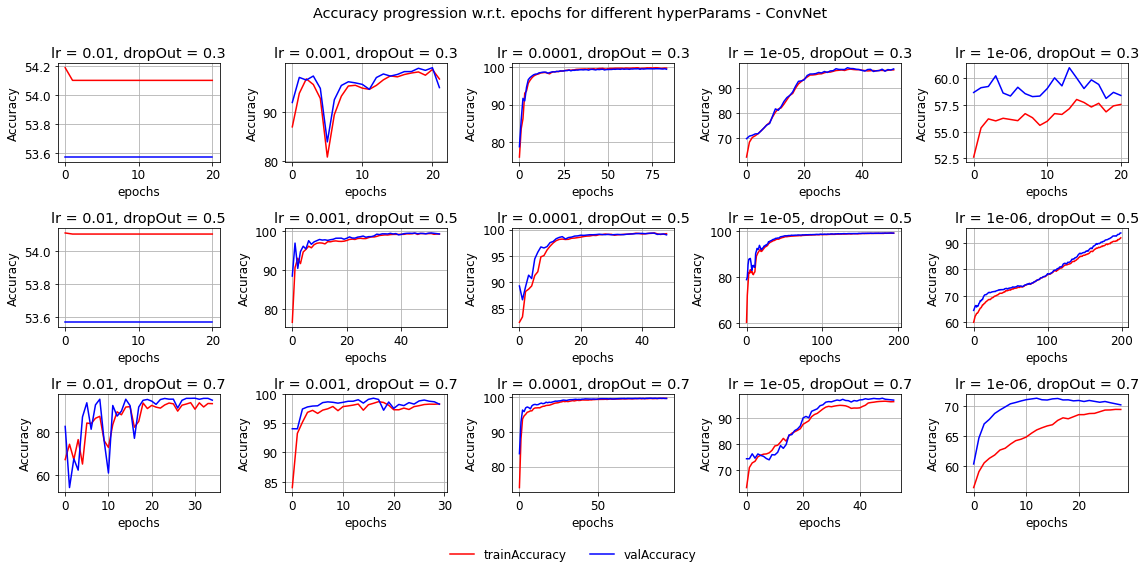

In [61]:
######################################################
# training/Val Accuracy progression
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (16,8)


numPlotRows = len(dropOutProbList)
numPlotCols = len(learningRateList)
fig, ax = plt.subplots(numPlotRows, numPlotCols)

for d, dropOutProb in enumerate(dropOutProbList):
    for l, learningRate in enumerate(learningRateList):
        
        # dummy plot to put the legend for loss in the same axis
        #ax[d,l].plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'loss', color = 'black')
        
        ax[d,l].plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'trainAccuracy', color = 'red')
        ax[d,l].plot(np.arange(numEpochs), valAccuracyProgression[d,l], label = 'valAccuracy', color = 'blue')        
        ax[d,l].set(xlabel = 'epochs', ylabel = 'Accuracy', title = f'lr = {learningRate}, dropOut = {dropOutProb}')
        #ax2 = ax[d,l].twinx()        
        
        #ax2.plot(np.arange(numEpochs), lossProgression[d,l], label = 'trainAccuracy', color = 'black')        
        #ax2.set_ylim([np.nanmin(lossProgression),np.nanmax(lossProgression)])
        ax[d,l].grid()
        #ax[d,l].legend(frameon=False, loc = 'center right')

handles, labels = ax[d,l].get_legend_handles_labels()
fig.legend(handles, labels, frameon = False, loc = 'lower center', ncol = len(labels))
fig.suptitle(f'Accuracy progression w.r.t. epochs for different hyperParams - {networkType}')
plt.tight_layout(rect = [0, 0.05, 1, 0.98])

outputImg = f'{plotImgDir}/lossAccuracyProgression_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

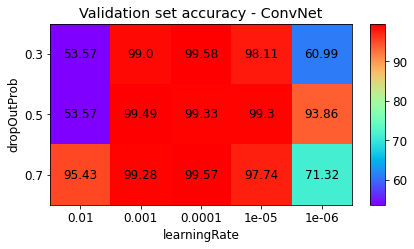

bestValAccuracy =  99.5774154663086
Best Validation accuracy achieved for dropOutProb = 0.3, learningRate = 0.0001


In [118]:
######################################################
# plot valAccuracy across the 2 shmoo params
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,6)

fig, ax = plt.subplots()
im = ax.imshow(bestValAccuracy, cmap='rainbow')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.25)
fig.colorbar(im, cax=cax)

ax.set_xticks(np.arange(len(learningRateList)))
ax.set_yticks(np.arange(len(dropOutProbList)))
ax.set_xticklabels(map(str, learningRateList))
ax.set_yticklabels(map(str, dropOutProbList))

ax.set(xlabel = 'learningRate', ylabel = 'dropOutProb', title = f'Validation set accuracy - {networkType}')

# add text labels to heatmap
for i in range(len(dropOutProbList)):
    for j in range(len(learningRateList)):
        ax.text(j, i, round(bestValAccuracy[i,j],2), ha='center', va='center', color = 'k')

outputImg = f'{plotImgDir}/hyperParamShmooValidationAccuracy_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

# find the index of best ValAccuracy
print (f'bestValAccuracy = ', np.max(bestValAccuracy))
d =  int(np.argmax(bestValAccuracy) / bestValAccuracy.shape[1])
l =  (np.argmax(bestValAccuracy) - d*bestValAccuracy.shape[1]) % bestValAccuracy.shape[1]
learningRate = learningRateList[l]
dropOutProb = dropOutProbList[d]
print (f'Best Validation accuracy achieved for dropOutProb = {dropOutProbList[d]}, learningRate = {learningRateList[l]}')

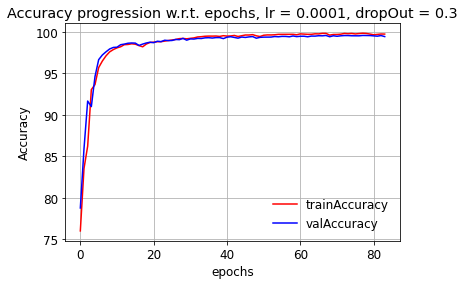

In [91]:
# plot the train/Val vs epoch curve for the bestVal hyperParams only

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,4)
fig, ax = plt.subplots()
ax.plot(np.arange(numEpochs), trainAccuracyProgression[d,l], label = 'trainAccuracy', color = 'red')
ax.plot(np.arange(numEpochs), valAccuracyProgression[d,l], label = 'valAccuracy', color = 'blue')        
ax.set(xlabel = 'epochs', ylabel = 'Accuracy', title = f'Accuracy progression w.r.t. epochs, lr = {learningRate}, dropOut = {dropOutProb}')
ax.grid()
ax.legend(frameon=False)
outputImg = f'{plotImgDir}/bestHyperParamLossAccuracyProgression_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

testSet Accuracy = 99.57743835449219
[[8853.   30.]
 [  39. 7407.]]


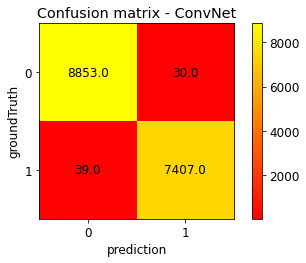

In [92]:
# find accuracy on the test set with the model giving the best validation accuracy

learningRate = learningRateList[l]
dropOutProb = dropOutProbList[d]
netParamsFileTag = f'batchSize_{batchSize}_learningRate_{learningRate}_dropOutProb_{dropOutProb}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
path = f'{netParamsDirName}/cnn3Layer_12_12_8_fc2layer_16_16_{netParamsFileTag}.pth'
net = Net()
net.load_state_dict(torch.load(path))
net.to(device)

# set network in eval mode
net.eval()

numErrors = 0.0
confusionMatrix = np.zeros((2,2))
with torch.no_grad():
    for i, data in enumerate(testGenerator, 0):

        inputBatch, groundTruthBatch = data
        inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

        outputPredBatch = net(inputBatch)

        # output prediction label
        outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))

        numErrors += (outputPredLabelBatch.squeeze() != groundTruthBatch).sum().float()
        
        # accumulate confusionMatrix
        confusionMatrix += confusion_matrix(groundTruthBatch.cpu().numpy(), outputPredLabelBatch.squeeze().cpu().numpy())

testAccuracy = 100 * (1 - numErrors/len(df_test))

print (f'testSet Accuracy = {testAccuracy}')

print (confusionMatrix)

# normalize confusion matrix
confusionMatrixNorm = confusionMatrix / np.sum(confusionMatrix, axis = 1)[:,None]

######################################################
# plot confusionMatrix
######################################################
mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (4,4)

fig, ax = plt.subplots()
im = ax.imshow(confusionMatrix, cmap='autumn')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size = '5%', pad = 0.25)
fig.colorbar(im, cax=cax)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(map(str, ['0','1']))
ax.set_yticklabels(map(str, ['0','1']))

ax.set(xlabel = 'prediction', ylabel = 'groundTruth', title = f'Confusion matrix - {networkType}')

# add text labels to heatmap
for i in range(2):
    for j in range(2):
        ax.text(j, i, round(confusionMatrix[i,j],3), ha='center', va='center', color = 'k')

outputImg = f'{plotImgDir}/confusionMatrix_{plotFileTag}.png'
fig.savefig(outputImg)
plt.show()
plt.close(fig)

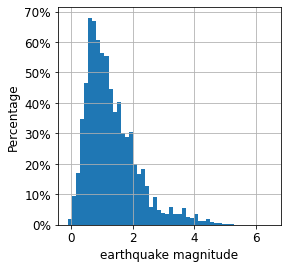

In [68]:
# plot histogram of earthquake magnitudes

from matplotlib.ticker import PercentFormatter

plt.rcParams['figure.figsize'] = (4,4) 
mpl.rcParams['font.size'] = 12
fig, ax = plt.subplots()
ax.hist(df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'], bins=50, density = True)
ax.set(xlabel='earthquake magnitude', ylabel='Percentage')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
fig.savefig(f'{plotImgDir}/earthquakeMagnitudeHistogram_{plotFileTag}.png')

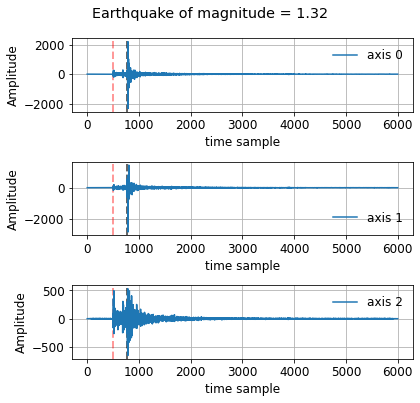

In [111]:
# plot earthquake waveforms of magnitude closer to mean of the distribution
meanEarthquakeMagnitude = df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'].mean()
meanIdx = abs(df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'] - meanEarthquakeMagnitude).idxmin()

dataset = hdf5Data.get('data/' + meanIdx)
data = np.array(dataset)
data = data.T

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,6) 
num_plt_rows = data.shape[0]
num_plt_cols = 1

fig, ax = plt.subplots(num_plt_rows, num_plt_cols)
for r in range(num_plt_rows):
    ax[r].axvline(df_csv.loc[meanIdx]['p_arrival_sample'], linestyle = '--', linewidth = 2, color = 'r', alpha = 0.4)
    ax[r].axvline(df_csv.loc[meanIdx]['s_arrival_sample'], linestyle = '--', linewidth = 2, color = 'k', alpha = 0.6)
    ax[r].plot(data[r,:], label = f'axis {r}')
    
    ax[r].set(xlabel = 'time sample', ylabel = 'Amplitude')
    ax[r].grid()
    ax[r].legend(frameon=False)

fig.suptitle(f"Earthquake of magnitude = {df_csv.loc[meanIdx]['source_magnitude']}")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/earthquakeExampleWaveform_{plotFileTag}.png')

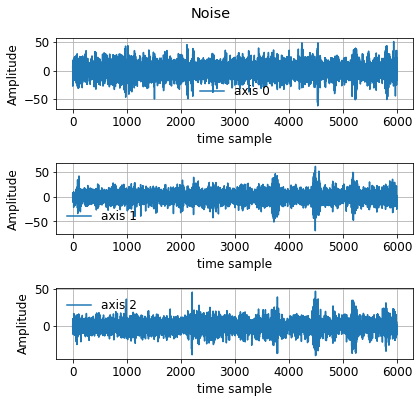

In [108]:
# plot a noise waveform 
randomIdx = df_csv[df_csv['trace_category'] == 'noise'].index[0]

dataset = hdf5Data.get('data/' + randomIdx)
data = np.array(dataset)
data = data.T

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (6,6) 
num_plt_rows = data.shape[0]
num_plt_cols = 1

fig, ax = plt.subplots(num_plt_rows, num_plt_cols)
for r in range(num_plt_rows):
    ax[r].plot(data[r,:], label = f'axis {r}')
    ax[r].set(xlabel = 'time sample', ylabel = 'Amplitude')
    ax[r].grid()
    ax[r].legend(frameon=False)

fig.suptitle(f"Noise")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/noiseExampleWaveform_{plotFileTag}.png')

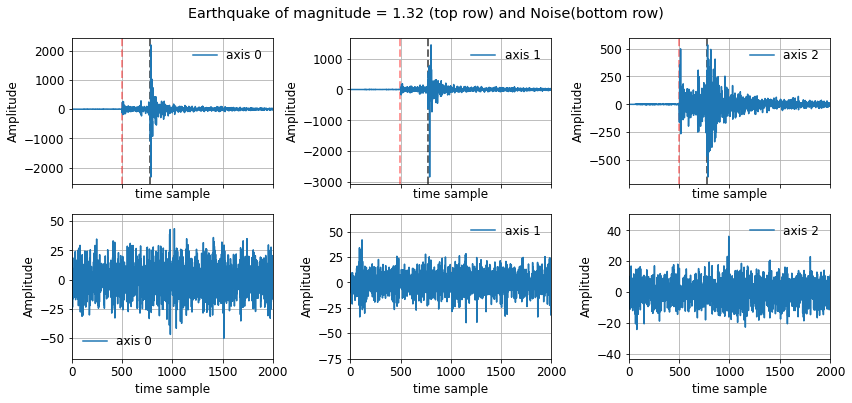

In [121]:
# modified plot for report

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12,6) 
num_plt_rows = 2
num_plt_cols = data.shape[0]

fig, ax = plt.subplots(num_plt_rows, num_plt_cols, sharex=True)
for r in range(num_plt_rows):
    
    if r == 0:
        
        meanEarthquakeMagnitude = df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'].mean()
        meanIdx = abs(df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'] - meanEarthquakeMagnitude).idxmin()
        dataset = hdf5Data.get('data/' + meanIdx)
        data = np.array(dataset)
        data = data.T
        
        for c in range(num_plt_cols):
            ax[r,c].axvline(df_csv.loc[meanIdx]['p_arrival_sample'], linestyle = '--', linewidth = 2, color = 'r', alpha = 0.4)
            ax[r,c].axvline(df_csv.loc[meanIdx]['s_arrival_sample'], linestyle = '--', linewidth = 2, color = 'k', alpha = 0.6)
            ax[r,c].plot(data[c,:], label = f'axis {c}')
            ax[r,c].set_xlim(0,2000)
            ax[r,c].set(xlabel = 'time sample', ylabel = 'Amplitude')
            ax[r,c].grid()
            ax[r,c].legend(frameon=False)
    else:
        randomIdx = df_csv[df_csv['trace_category'] == 'noise'].index[0]
        dataset = hdf5Data.get('data/' + randomIdx)
        data = np.array(dataset)
        data = data.T
        for c in range(num_plt_cols):
            ax[r,c].plot(data[c,:], label = f'axis {c}')
            ax[r,c].set(xlabel = 'time sample', ylabel = 'Amplitude')
            ax[r,c].set_xlim(0,2000)
            ax[r,c].grid()
            ax[r,c].legend(frameon=False)
    
fig.suptitle(f"Earthquake of magnitude = {df_csv.loc[meanIdx]['source_magnitude']} (top row) and Noise(bottom row)")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/earthquakeAndNoiseSnippetExampleWaveform_{plotFileTag}.png')




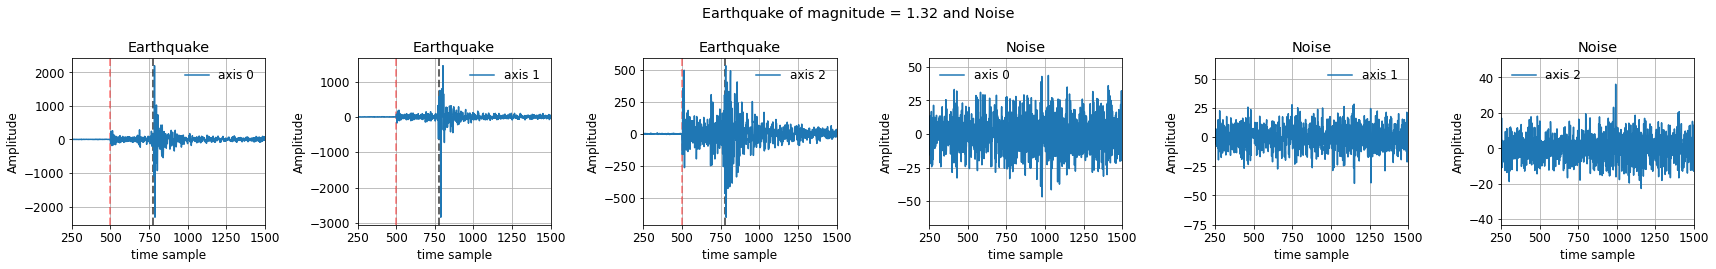

In [138]:
# modified plot for report

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (24,4) 
num_plt_rows = 1
num_plt_cols = 6

fig, ax = plt.subplots(num_plt_rows, num_plt_cols, sharex=True)
for c in range(num_plt_cols):
    
    if c < 3:
        
        meanEarthquakeMagnitude = df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'].mean()
        meanIdx = abs(df_csv[df_csv['trace_category'] == 'earthquake_local']['source_magnitude'] - meanEarthquakeMagnitude).idxmin()
        dataset = hdf5Data.get('data/' + meanIdx)
        data = np.array(dataset)
        data = data.T
        
        ax[c].axvline(df_csv.loc[meanIdx]['p_arrival_sample'], linestyle = '--', linewidth = 2, color = 'r', alpha = 0.4)
        ax[c].axvline(df_csv.loc[meanIdx]['s_arrival_sample'], linestyle = '--', linewidth = 2, color = 'k', alpha = 0.6)
        ax[c].plot(data[c,:], label = f'axis {c}')
        ax[c].set_xlim(250,1500)
        ax[c].set(xlabel = 'time sample', ylabel = 'Amplitude', title = 'Earthquake')
        ax[c].grid()
        ax[c].legend(frameon=False)
    else:
        randomIdx = df_csv[df_csv['trace_category'] == 'noise'].index[0]
        dataset = hdf5Data.get('data/' + randomIdx)
        data = np.array(dataset)
        data = data.T
        ax[c].plot(data[c-3,:], label = f'axis {c-3}')
        ax[c].set(xlabel = 'time sample', ylabel = 'Amplitude', title = 'Noise')
        ax[c].set_xlim(250,1500)
        ax[c].grid()
        ax[c].legend(frameon=False)
    
fig.suptitle(f"Earthquake of magnitude = {df_csv.loc[meanIdx]['source_magnitude']} and Noise")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/earthquakeAndNoiseSnippetExampleWaveform_{plotFileTag}.png')

In [59]:
print ('Train set length = ', len(df_train))
print ('Val set length = ', len(df_val))
print ('Test set length = ', len(df_test))

# dump train/val/test CSVs to a dir
csvDir = 'outputCsv/cnn1d'
csvFileTag = f'batchSize_{batchSize}_numEpochs_{numEpochs}_dataFraction_{earthquakeSampleFraction}_{noiseSampleFraction}'
os.system(f'mkdir -p {csvDir}')
df_train.to_csv(f'{csvDir}/train_{csvFileTag}.csv')
df_val.to_csv(f'{csvDir}/val_{csvFileTag}.csv')
df_test.to_csv(f'{csvDir}/test_{csvFileTag}.csv')

Train set length =  76199
Val set length =  16328
Test set length =  16329


In [126]:
# find false positive/negative waveforms

# set network in eval mode
falsePositiveWaveforms = []
falseNegativeWaveforms = []

net.eval()
with torch.no_grad():
    for i, data in enumerate(testGenerator, 0):

        inputBatch, groundTruthBatch = data
        inputBatch, groundTruthBatch = inputBatch.to(device), groundTruthBatch.to(device)

        outputPredBatch = net(inputBatch)

        # output prediction label
        outputPredLabelBatch = torch.round(torch.sigmoid(outputPredBatch))
                
        keyTupleList = list(zip(groundTruthBatch.cpu().numpy(), outputPredLabelBatch.squeeze().cpu().numpy()))
        inputBatch = inputBatch.cpu().numpy()
        
        for i, keyVal in enumerate(keyTupleList):
            
            # false positive
            if (keyVal[0] == 0) & (keyVal[1] == 1):
                falsePositiveWaveforms.append(inputBatch[i,:])                        
            
            # false negative
            if (keyVal[0] == 1) & (keyVal[1] == 0):
                falseNegativeWaveforms.append(inputBatch[i,:]) 




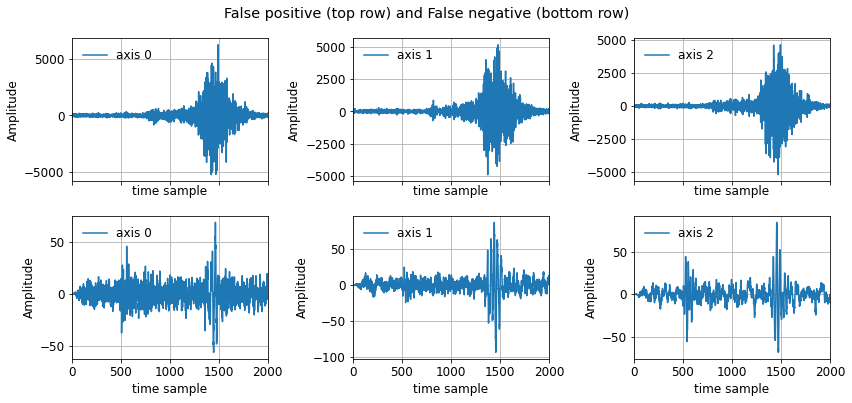

In [130]:
# plot false positive and negative

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (12,6) 
num_plt_rows = 2
num_plt_cols = 3

fig, ax = plt.subplots(num_plt_rows, num_plt_cols, sharex=True)
for r in range(num_plt_rows):
    
    if r == 0:                
        for c in range(num_plt_cols):
            ax[r,c].plot(falsePositiveWaveforms[0][c,:], label = f'axis {c}')
            ax[r,c].set_xlim(0,2000)
            ax[r,c].set(xlabel = 'time sample', ylabel = 'Amplitude')
            ax[r,c].grid()
            ax[r,c].legend(frameon=False)
    else:
        for c in range(num_plt_cols):
            ax[r,c].plot(falseNegativeWaveforms[0][c,:], label = f'axis {c}')
            ax[r,c].set(xlabel = 'time sample', ylabel = 'Amplitude')
            ax[r,c].set_xlim(0,2000)
            ax[r,c].grid()
            ax[r,c].legend(frameon=False)
    
fig.suptitle(f"False positive (top row) and False negative (bottom row)")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/falsePositiveAndNegativeSnippetExampleWaveform_{plotFileTag}.png')



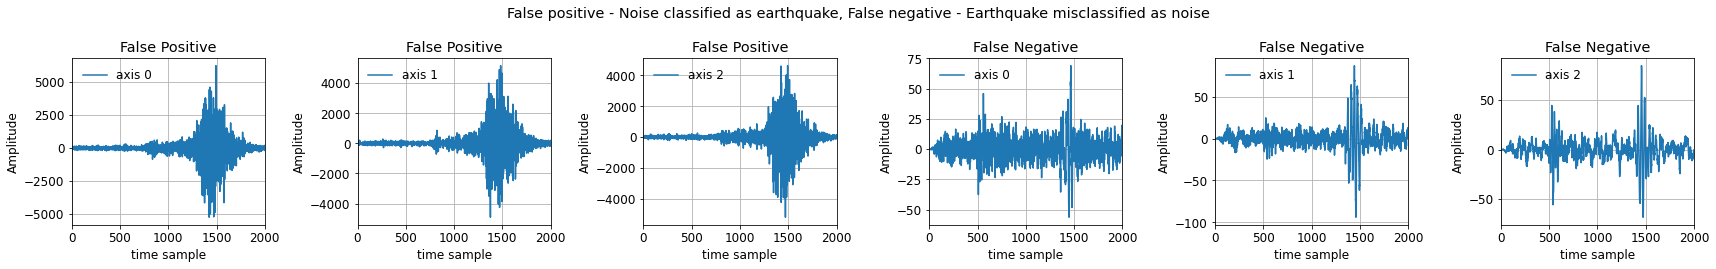

In [142]:
# plot false positive and negative in row major form

mpl.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (24,4) 
num_plt_rows = 1
num_plt_cols = 6

fig, ax = plt.subplots(num_plt_rows, num_plt_cols, sharex=True)
for c in range(num_plt_cols):
    
    if c < 3:                        
        ax[c].plot(falsePositiveWaveforms[0][c,:], label = f'axis {c}')
        ax[c].set_xlim(0,2000)
        ax[c].set(xlabel = 'time sample', ylabel = 'Amplitude', title = 'False Positive')
        ax[c].grid()
        ax[c].legend(frameon=False)
    else:        
        ax[c].plot(falseNegativeWaveforms[0][c-3,:], label = f'axis {c-3}')
        ax[c].set(xlabel = 'time sample', ylabel = 'Amplitude', title = 'False Negative')
        ax[c].set_xlim(0,2000)
        ax[c].grid()
        ax[c].legend(frameon=False)
    
fig.suptitle(f"False positive - Noise classified as earthquake, False negative - Earthquake misclassified as noise")
plt.tight_layout(rect = [0, 0.05, 1, 1])
fig.savefig(f'{plotImgDir}/falsePositiveAndNegativeSnippetExampleWaveform_{plotFileTag}.png')